In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pyeit.eit.utils import eit_scan_lines
import pandas as pd
from pyeit.mesh.meshpy.build import create
import pyeit.eit.jac as jac

# Run the Image Reconstruction

In [41]:
MANUAL_MASK_PATH = 'gt_1.png' 
HOMOGEN_PATH = r'SIMULASI\OBJEK 1\1_FAT_HOM.csv'
INCLUSION_PATH = r'SIMULASI\OBJEK 1\1_M_F_OBJ.csv'

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyeit.mesh.meshpy.build import create
import pyeit.mesh as mesh
from pyeit.eit.fem import Forward # For forward problem simulation
import pyeit.eit.jac as jac # For inverse problem (classical method)
import os
import cv2

Arbitrary-shaped mesh created successfully.


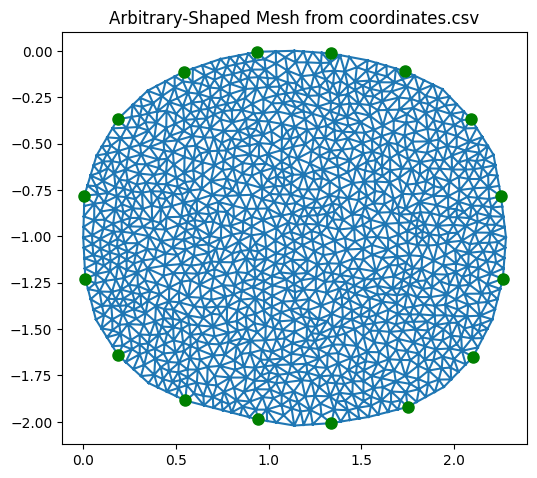

In [163]:
# --- Custom Mesh Creation ---
# This uses the same function structure as your working notebook
def create_custom_boundary_func(csv_path):
    """ 
    This function returns another function that will be used as the 'curve'
    argument in the older pyeit.mesh.create.
    """
    try:
        # Using header=None and decimal=',' for robustness as determined in Task 1
        data = pd.read_csv(csv_path, dtype=np.float64)
        X = data.iloc[:, 1]  # Assuming the second column is X
        Y = data.iloc[:, 2]  # Assuming the third column is Y
        scaled_points = list(zip(X, Y))
        def curve_func(n_el=16):
            return scaled_points, [len(scaled_points)]
        return curve_func
    except FileNotFoundError:
        print(f"Error: The file '{csv_path}' was not found.")
        return None

# --- Configuration ---
N_el = 16
MAX_TRIANGLE_AREA = 0.0025 
# Use a raw string for the file path to avoid issues with backslashes
CSV_PATH = r"SIMULASI\OBJEK 1\OBJ1.csv"

# Create the function that will define our custom boundary
custom_curve_function = create_custom_boundary_func(CSV_PATH)

if custom_curve_function is not None:
    # Use the create function from the downgraded API
    mesh_obj, el_pos_from_create = create(num_el=N_el, 
                                          max_area=MAX_TRIANGLE_AREA, 
                                          curve=custom_curve_function, 
                                          refine=True)

    # *** UPDATED: Define el_pos using the arithmetic method from your notebook ***
    # This assumes the 32 boundary points are ordered. For 16 electrodes, the step is 2.
    num_boundary_pts = 32 # Based on the standard from your CSV files
    step = num_boundary_pts // N_el
    el_pos = np.array([step * i for i in range(N_el)])

    # Assemble the final arbitrary mesh object
    arbitrary_mesh = {
        'node': mesh_obj['node'],
        'element': mesh_obj['element'],
        'el_pos': el_pos,
        'perm': np.ones(len(mesh_obj['element']))
    }
    print("Arbitrary-shaped mesh created successfully.")

    # --- Visualize the new mesh for verification ---
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.triplot(arbitrary_mesh['node'][:, 0], arbitrary_mesh['node'][:, 1], arbitrary_mesh['element'])
    ax.plot(arbitrary_mesh['node'][el_pos, 0], arbitrary_mesh['node'][el_pos, 1], 'go', markersize=8)
    ax.set_title('Arbitrary-Shaped Mesh from coordinates.csv')
    ax.set_aspect('equal')
    plt.show()
else:
    print("Mesh creation failed.")

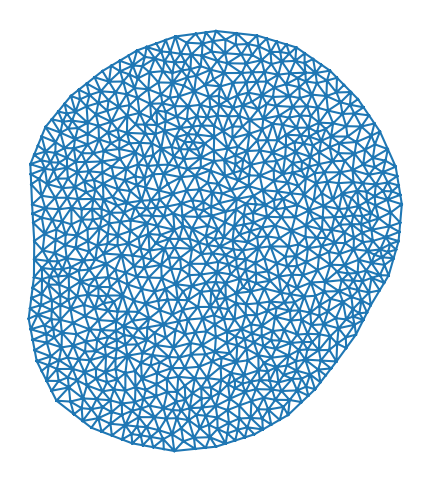

In [94]:
# --- Visualize the new mesh for verification ---
fig, ax = plt.subplots(figsize=(6, 6))
ax.triplot(arbitrary_mesh['node'][:, 0], arbitrary_mesh['node'][:, 1], arbitrary_mesh['element'])
ax.set_aspect('equal')
ax.axis('off')
plt.savefig(
    'objek2.png', 
    dpi=300, 
    bbox_inches='tight', 
    pad_inches=0
)
plt.show()

In [159]:
def render_mesh_to_image(mesh, data_vector, image_size=(128, 128), is_binary=False):
    """
    Renders a 1D data vector (permittivity or reconstruction) from a mesh into a 2D image.
    """
    # Robust scaling for arbitrary shapes to maintain aspect ratio
    nodes = mesh['node']
    min_coords = np.min(nodes, axis=0)
    max_coords = np.max(nodes, axis=0)
    span = max_coords - min_coords
    
    scale = min(image_size[0] / span[0], image_size[1] / span[1]) if np.all(span > 0) else 1
    
    pts_scaled = (nodes - min_coords) * scale
    offset = (np.array(image_size) - np.max(pts_scaled, axis=0)) / 2
    pts = (pts_scaled + offset).astype(int)
    
    if is_binary:
        img = np.zeros(image_size, dtype=np.uint8)
    else:
        img = np.full(image_size, 255, dtype=np.float32)

    elements = mesh['element']
    
    if not is_binary and np.max(data_vector) > np.min(data_vector):
        data_normalized = 255 * (data_vector - np.min(data_vector)) / (np.max(data_vector) - np.min(data_vector))
    else:
        data_normalized = data_vector
        
    for i, element in enumerate(elements):
        triangle = np.array([tuple(pts[p]) for p in element])
        if is_binary:
            if data_vector[i] > 0:
                cv2.fillPoly(img, [triangle], color=255)
        else:
            cv2.fillPoly(img, [triangle], color=float(data_normalized[i]))
            
    # *** FIXED: Add a vertical flip to correct the orientation ***
    # The mesh y-axis points up, while the image y-axis points down.
    # We flip the image vertically (0) to align them.
    img_flipped = cv2.flip(img, 0)

    return img_flipped.astype(np.uint8)

In [103]:
MASK_PATH1 = 'gt_1.png' 
HOMOGEN_PATH1 = r'SIMULASI\OBJEK 1\1_FAT_HOM.csv'
INCLUSION_PATH1 = r'SIMULASI\OBJEK 1\1_M_F_OBJ.csv'

MASK_PATH2 = 'gt_2.png' 
HOMOGEN_PATH2 = r'SIMULASI\OBJEK 2\2_FAT_HOM.csv'
INCLUSION_PATH2 = r'SIMULASI\OBJEK 2\2_MEAT_FAT_OBJ.csv'

MASK_PATH3 = 'gt_3.png' 
HOMOGEN_PATH3 = r'SIMULASI\OBJEK 3\3_FAT_HOM.csv'
INCLUSION_PATH3 = r'SIMULASI\OBJEK 3\3_MEAT_FAT_OBJ.csv'

In [164]:
# List of p-values to use for data augmentation
NUM_P_VALUES = 20
P_VALUES_FOR_AUGMENTATION = np.linspace(0.05, 1.0, NUM_P_VALUES)

# Define your experimental data files and corresponding manual masks
# Add more experiments to this list as you get more data
EXPERIMENTS = [
    {
        "homogen_voltages": HOMOGEN_PATH1,
        "inclusion_voltages": INCLUSION_PATH1, 
        "manual_mask": MASK_PATH1 
    },
    # {
    #     "homogen_voltages": HOMOGEN_PATH2,
    #     "inclusion_voltages": INCLUSION_PATH2,
    #     "manual_mask": MASK_PATH2
    # },
    # {
    #     "homogen_voltages": HOMOGEN_PATH3,
    #     "inclusion_voltages": INCLUSION_PATH3,
    #     "manual_mask": MASK_PATH3
    # }
]

DATASET_DIR = "eit_dataset_experimental"
INPUTS_DIR = os.path.join(DATASET_DIR, "inputs")
MASKS_DIR = os.path.join(DATASET_DIR, "masks")
os.makedirs(INPUTS_DIR, exist_ok=True)
os.makedirs(MASKS_DIR, exist_ok=True)

# --- Setup EIT Solver ---
if 'arbitrary_mesh' in locals():
    ex_mat = eit_scan_lines(N_el, 1)
    eit_inverse = jac.JAC(arbitrary_mesh, el_pos, ex_mat=ex_mat, step=1, perm=1.0)

    # --- Generation Loop ---
    print(f"\n--- Generating dataset from {len(EXPERIMENTS)} experiments... ---")
    image_counter = 0
    for i, exp in enumerate(EXPERIMENTS):
        print(f"  Processing experiment {i+1}...")
        # 1. Load the ground truth mask
        mask_image = cv2.imread(exp["manual_mask"], cv2.IMREAD_GRAYSCALE)
        
        # *** FIXED: Add a check to ensure the mask image was loaded correctly ***
        if mask_image is None:
            print(f"    Warning: Could not load the mask file '{exp['manual_mask']}'. Skipping this experiment.")
            continue # Skip to the next experiment
        
        # Resize to the target image size for the neural network
        mask_image_resized = cv2.resize(mask_image, (128, 128))

        # 2. Load the voltage data for this experiment
        try:
            vh = pd.read_csv(exp["homogen_voltages"])['Vm'].values
            vi = pd.read_csv(exp["inclusion_voltages"])['Vm'].values
        except FileNotFoundError:
            print(f"    Warning: Could not find voltage files for experiment {i+1}. Skipping.")
            continue
        except KeyError:
            print(f"    Warning: Column 'Vm' not found in CSV for experiment {i+1}. Skipping.")
            continue


        # 3. Loop through p-values to create augmented inputs
        for p_val in P_VALUES_FOR_AUGMENTATION:
            # Set up solver with the current p-value
            eit_inverse.setup(p=p_val, lamb=0.25, method='kotre')
            # Solve to get the blurry reconstruction
            ds = eit_inverse.solve(vi, vh, normalize=True)
            
            # Render this reconstruction to an image
            input_image = render_mesh_to_image(arbitrary_mesh, ds)
            
            # 4. Save the input image and its corresponding ground truth mask
            cv2.imwrite(os.path.join(INPUTS_DIR, f"image_{image_counter}.png"), input_image)
            cv2.imwrite(os.path.join(MASKS_DIR, f"mask_{image_counter}.png"), mask_image_resized)
            image_counter += 1
            
    print(f"\n--- Dataset generation complete! Generated {image_counter} image pairs. ---")
else:
    print("\nDataset generation skipped because mesh creation failed.")


--- Generating dataset from 1 experiments... ---
  Processing experiment 1...

--- Dataset generation complete! Generated 20 image pairs. ---


# DL

In [142]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [180]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1 # Grayscale images

input_files = sorted(os.listdir(INPUTS_DIR), key=lambda f: int(f.split('_')[1].split('.')[0]))
mask_files = sorted(os.listdir(MASKS_DIR), key=lambda f: int(f.split('_')[1].split('.')[0]))

# Create full paths
input_paths = [os.path.join(INPUTS_DIR, f) for f in input_files]
mask_paths = [os.path.join(MASKS_DIR, f) for f in mask_files]

# Keep track of original indices to map back to p_values later
original_indices = np.arange(len(input_paths))

# Split indices instead of paths to maintain the mapping
train_indices, val_indices = train_test_split(
    original_indices, test_size=0.2, random_state=42)

def load_and_preprocess_image(path):
    """ Loads and prepares a single image. """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = np.expand_dims(img, axis=-1) # Add channel dimension
    img = img / 255.0 # Normalize to [0, 1]
    return img

# Load all data first
all_X = np.array([load_and_preprocess_image(p) for p in input_paths], dtype=np.float32)
all_y = np.array([load_and_preprocess_image(p) for p in mask_paths], dtype=np.float32)

# Create train and validation sets using the indices
X_train, y_train = all_X[train_indices], all_y[train_indices]
X_val, y_val = all_X[val_indices], all_y[val_indices]


print(f"\nData loaded and preprocessed:")
print(f"Training images shape: {X_train.shape}")
print(f"Training masks shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}")
print(f"Validation masks shape: {y_val.shape}")


Data loaded and preprocessed:
Training images shape: (48, 128, 128, 1)
Training masks shape: (48, 128, 128, 1)
Validation images shape: (12, 128, 128, 1)
Validation masks shape: (12, 128, 128, 1)


In [181]:
def iou_loss(y_true, y_pred, smooth=1e-6):
    """
    Intersection over Union (IoU) loss function.
    IoU = |A intersect B| / |A union B|
    Loss = 1 - IoU
    """
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou

In [182]:
def build_unet(input_shape):
    """ Builds a standard U-Net model. """
    inputs = Input(input_shape)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

LEARNING_RATE = 0.0001
model = build_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=iou_loss, metrics=['accuracy'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │        160 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_8     │ (None, 64, 64,    │          0 │ conv2d_26[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 64, 64,    │          0 │ up_sampling2d_8[… │
│ (Concatenate)       │ 96)               │            │ conv2d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │     27,680 │ concatenate_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 128, 128,  │          0 │ conv2d_27[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 128, 128,  │          0 │ up_sampling2d_9[… │
│ (Concatenate)       │ 48)               │            │ conv2d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 128, 128,  │      6,928 │ concatenate_9[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │         17 │ conv2d_28[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,921 (226.25 KB)

 Trainable params: 57,921 (226.25 KB)

 Non-trainable params: 0 (0.00 B)

In [183]:
EPOCHS = 100
BATCH_SIZE = 4

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# Save the trained model for later use
model.save("unet_eit_model.h5")
print("\n--- Model training complete and saved as unet_eit_model.h5 ---")

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6401 - loss: 0.4205 - val_accuracy: 0.6470 - val_loss: 0.3519
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6245 - loss: 0.3700 - val_accuracy: 0.6470 - val_loss: 0.3376
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6324 - loss: 0.3547 - val_accuracy: 0.6470 - val_loss: 0.3348
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6377 - loss: 0.3461 - val_accuracy: 0.6470 - val_loss: 0.3337
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6346 - loss: 0.3477 - val_accuracy: 0.6470 - val_loss: 0.3318
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6316 - loss: 0.3492 - val_accuracy: 0.6470 - val_loss: 0.3282
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6392 - loss: 0.3395 - val_accuracy: 0.6477 - val_loss: 0.3223
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6465 - loss: 0.3284 - val_accuracy: 0.


--- Model training complete and saved as unet_eit_model.h5 ---


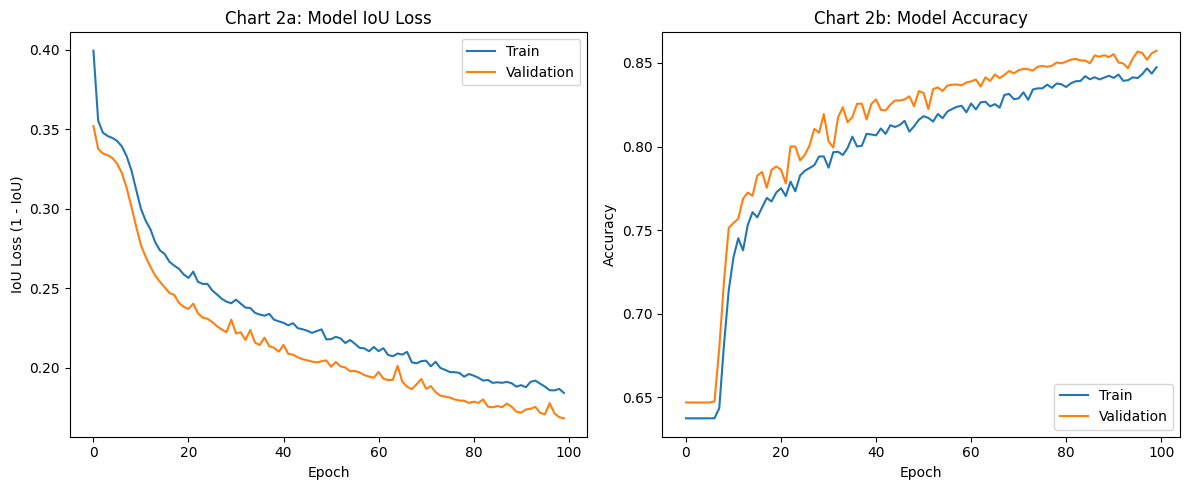

In [184]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Chart 2a: Model IoU Loss')
plt.ylabel('IoU Loss (1 - IoU)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Chart 2b: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [185]:
def plot_predictions(model, X_val, y_val, num_samples=3):
    """ Plots the input, ground truth, and prediction for a few samples. """
    # Select random samples from the validation set
    idx = np.random.choice(len(X_val), num_samples, replace=False)
    
    for i in idx:
        input_img = X_val[i]
        true_mask = y_val[i]
        
        # Predict the mask
        pred_mask = model.predict(np.expand_dims(input_img, axis=0))[0]
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.title("Input (Classical EIT)")
        plt.imshow(input_img[:, :, 0], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(true_mask[:, :, 0], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title("U-Net Predicted Mask")
        plt.imshow(pred_mask[:, :, 0], cmap='gray')
        plt.axis('off')
        
        plt.show()


--- Visualizing Predictions on Validation Data ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


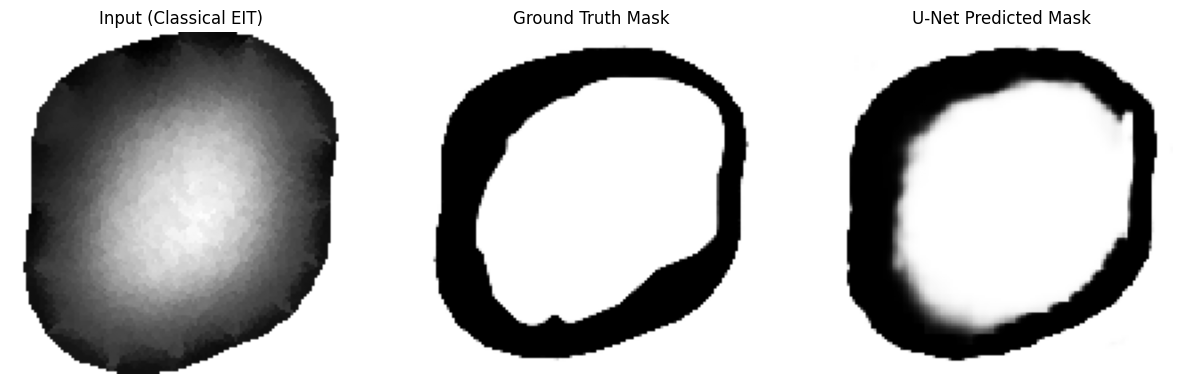

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


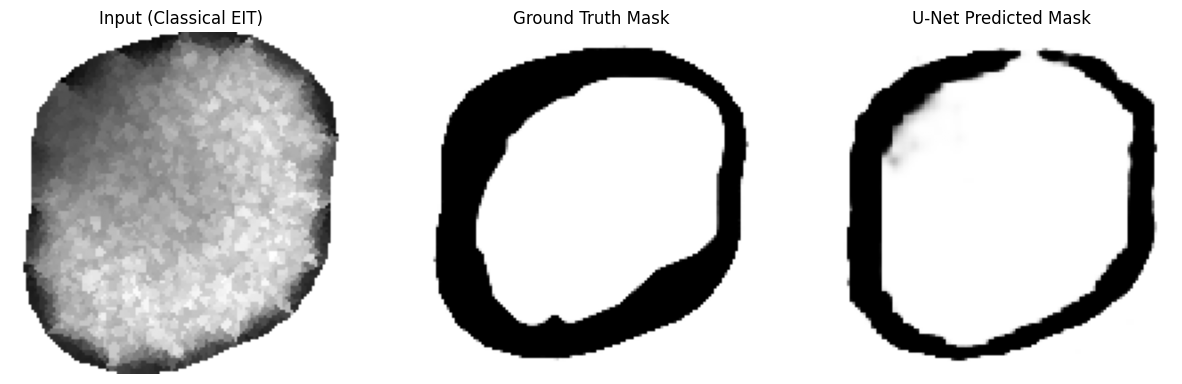

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


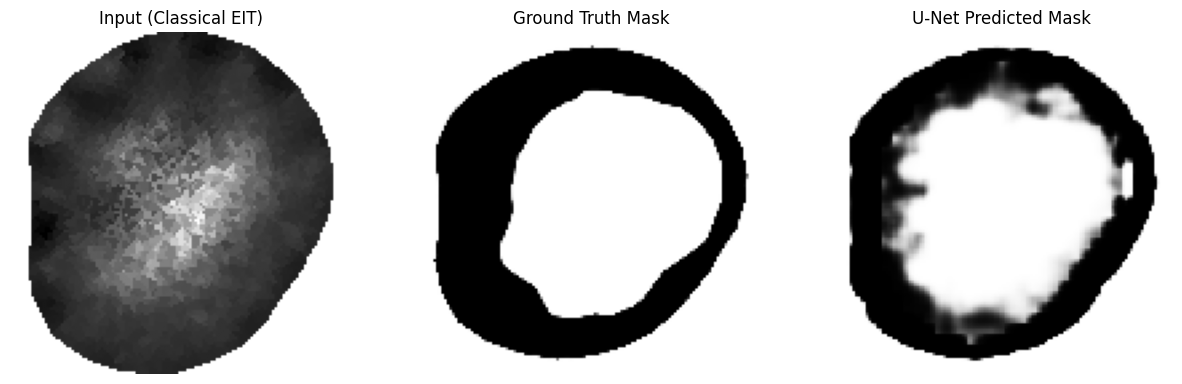

In [188]:
print("\n--- Visualizing Predictions on Validation Data ---")
plot_predictions(model, X_val, y_val)


--- Final Analysis and Comparison ---

--- Evaluating U-Net Performance vs. pVal ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step

--- Evaluating Classical Performance vs. pVal (on validation set) ---

--- Final Results ---
Classical method IoU scores by pVal: {np.float64(0.05): np.float64(0.4140577670919956), np.float64(0.1): 0, np.float64(0.15): 0, np.float64(0.2): 0, np.float64(0.25): 0, np.float64(0.3): np.float64(0.6038632431295468), np.float64(0.35): np.float64(0.7476129807548143), np.float64(0.39999999999999997): 0, np.float64(0.44999999999999996): np.float64(0.7484875864449843), np.float64(0.49999999999999994): 0, np.float64(0.5499999999999999): np.float64(0.6373458041193464), np.float64(0.6): 0, np.float64(0.65): np.float64(0.6393707183882914), np.float64(0.7): np.float64(0.5816708318453603), np.float64(0.75): np.float64(0.4701111183611066), np.float64(0.7999999999999999): 0, np.float64(0.85): np.float64(0.47676716184470164), np.float64(0.9): np.float64(0.39768868235560745), np.flo

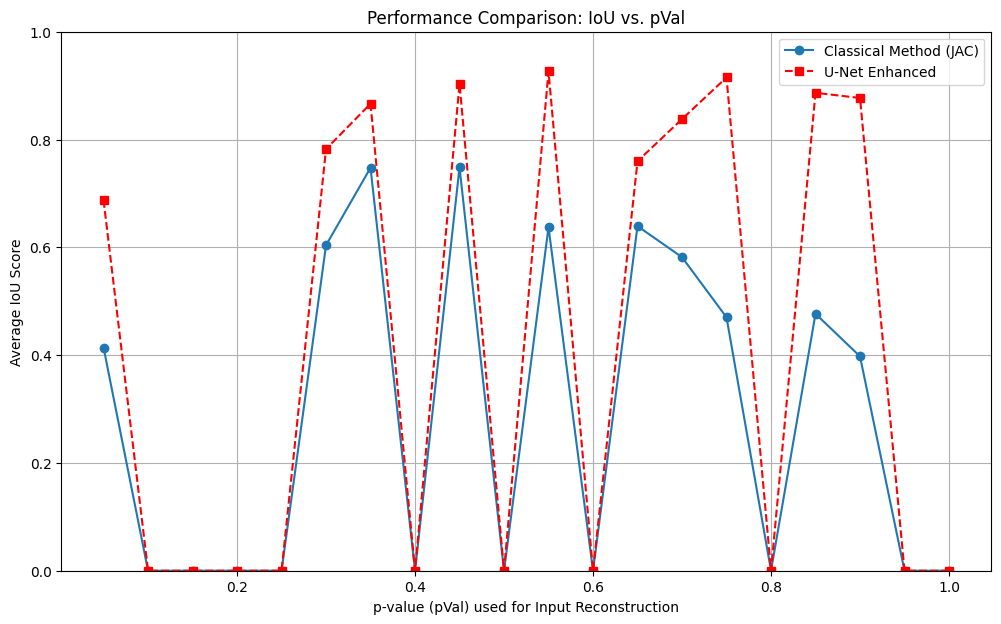

In [ ]:
def calculate_iou_numpy(y_true, y_pred, smooth=1e-6):
    """ Calculates IoU for two NumPy arrays. """
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def analyze_and_compare_performance(p_values, experiments_list, model, 
                                    X_val_data, y_val_data, val_indices_map):
    """ 
    Analyzes classical and U-Net performance and plots both as curves vs pVal.
    """
    num_p_values = len(p_values)
    
    # Dictionaries to hold IoU scores for each pVal
    classical_iou_by_pval = {p: [] for p in p_values}
    unet_iou_by_pval = {p: [] for p in p_values}

    # --- Part 1: Evaluate U-Net on the validation set and group by pVal ---
    print("\n--- Evaluating U-Net Performance vs. pVal ---")
    y_pred = model.predict(X_val_data)
    y_pred_binary = (y_pred > 0.5).astype(np.float32)

    for i, original_idx in enumerate(val_indices_map):
        p_val_index = original_idx % num_p_values
        p_val = p_values[p_val_index]
        
        iou = calculate_iou_numpy(y_val_data[i], y_pred_binary[i])
        unet_iou_by_pval[p_val].append(iou)

    # --- Part 2: Evaluate Classical Method on the validation set and group by pVal ---
    print("\n--- Evaluating Classical Performance vs. pVal (on validation set) ---")
    for i, original_idx in enumerate(val_indices_map):
        p_val_index = original_idx % num_p_values
        p_val = p_values[p_val_index]
        
        # The input image IS the classical reconstruction
        input_img = (X_val_data[i] * 255).astype(np.uint8)
        true_mask_img = (y_val_data[i] * 255).astype(np.uint8)
        
        _, input_mask = cv2.threshold(input_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        input_mask_norm = input_mask / 255.0
        true_mask_norm = true_mask_img / 255.0
        
        iou = calculate_iou_numpy(true_mask_norm, input_mask_norm)
        classical_iou_by_pval[p_val].append(iou)
        
    # --- Part 3: Calculate averages and plot ---
    avg_classical_iou = {p: np.mean(scores) if scores else 0 for p, scores in classical_iou_by_pval.items()}
    avg_unet_iou = {p: np.mean(scores) if scores else 0 for p, scores in unet_iou_by_pval.items()}
    
    print("\n--- Final Results ---")
    print(f"Classical method IoU scores by pVal: {avg_classical_iou}")
    print(f"U-Net method IoU scores by pVal: {avg_unet_iou}")
    
    plt.figure(figsize=(12, 7))
    plt.plot(list(avg_classical_iou.keys()), list(avg_classical_iou.values()), marker='o', linestyle='-', label='Classical Method (JAC)')
    plt.plot(list(avg_unet_iou.keys()), list(avg_unet_iou.values()), marker='s', linestyle='--', color='r', label='U-Net Enhanced')
    
    plt.title('Performance Comparison: IoU vs. pVal')
    plt.xlabel('p-value (pVal) used for Input Reconstruction')
    plt.ylabel('Average IoU Score')
    plt.ylim(0, 1.0)
    plt.grid(True)
    plt.legend()
    plt.show()

# Run the final analysis and comparison function
print("\n--- Final Analysis and Comparison ---")
if 'model' in locals():
    analyze_and_compare_performance(P_VALUES_FOR_AUGMENTATION, EXPERIMENTS, model, X_val, y_val, val_indices)
else:
    print("Model not trained. Please run all cells above first.")


--- Final Analysis and Comparison ---

--- Analyzing Performance for: Object 1 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


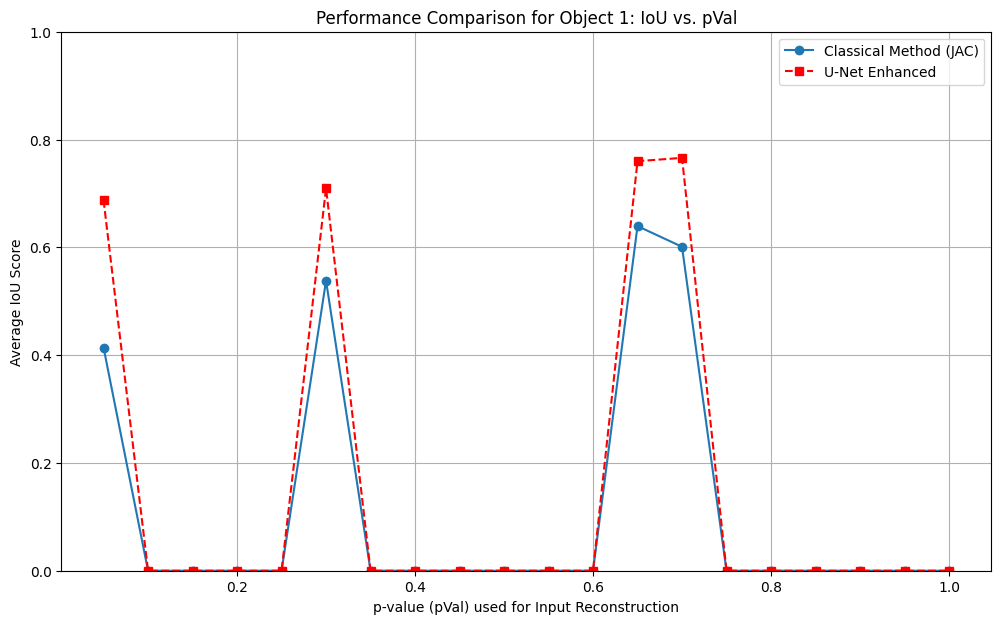


--- Analyzing Performance for: Object 2 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


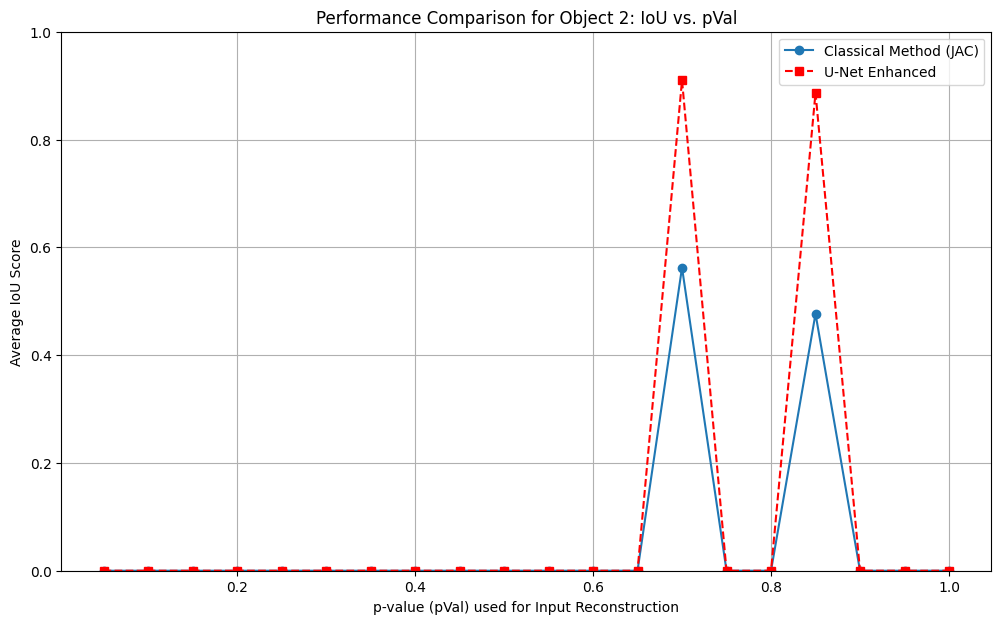


--- Analyzing Performance for: Object 3 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


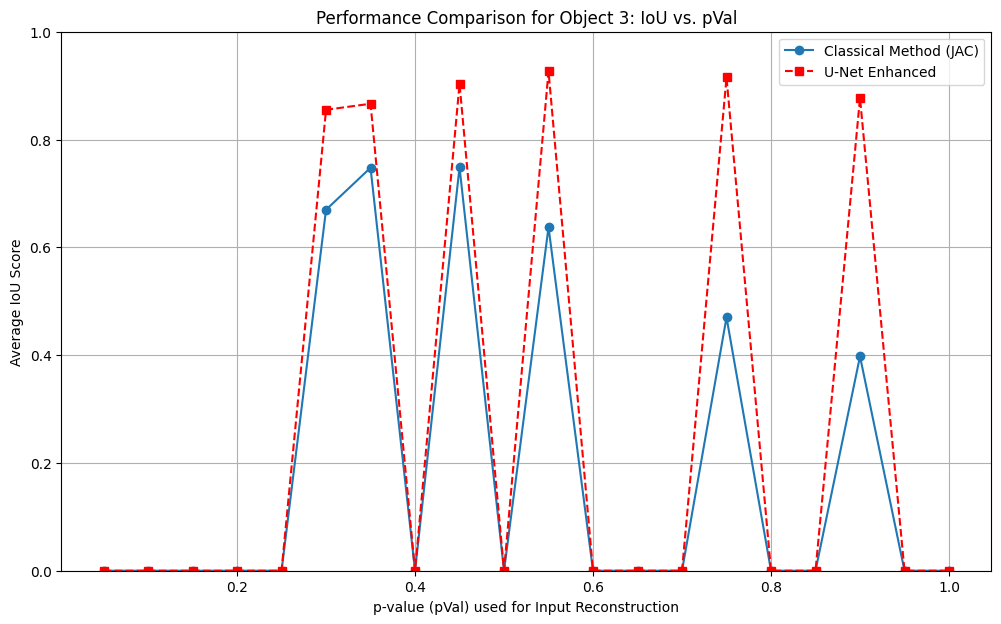

In [194]:
def calculate_iou_numpy(y_true, y_pred, smooth=1e-6):
    """ Calculates IoU for two NumPy arrays. """
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def analyze_and_compare_performance_per_object(p_values, model, 
                                               all_X_data, all_y_data, val_indices_map):
    """ 
    Analyzes classical and U-Net performance for each object and plots a
    separate comparison chart for each.
    """
    num_p_values = len(p_values)
    num_total_images = len(all_X_data)
    num_objects = num_total_images // num_p_values

    # --- Loop through each object based on image indices ---
    for obj_idx in range(num_objects):
        print(f"\n--- Analyzing Performance for: Object {obj_idx + 1} ---")
        
        # Dictionaries to hold IoU scores for the current object
        classical_iou_by_pval = {p: [] for p in p_values}
        unet_iou_by_pval = {p: [] for p in p_values}

        # Find which indices in the validation set belong to this object
        val_indices_for_this_obj = [i for i, orig_idx in enumerate(val_indices_map) if (orig_idx // num_p_values) == obj_idx]
        
        if not val_indices_for_this_obj:
            print(f"No validation samples found for Object {obj_idx + 1}. Skipping.")
            continue
            
        # Get the validation data specific to this object
        X_val_obj = all_X_data[val_indices_map[val_indices_for_this_obj]]
        y_val_obj = all_y_data[val_indices_map[val_indices_for_this_obj]]
        
        # --- Evaluate U-Net Performance for this object ---
        y_pred = model.predict(X_val_obj)
        y_pred_binary = (y_pred > 0.5).astype(np.float32)

        for i in range(len(X_val_obj)):
            original_idx = val_indices_map[val_indices_for_this_obj[i]]
            p_val_index = original_idx % num_p_values
            p_val = p_values[p_val_index]
            
            iou = calculate_iou_numpy(y_val_obj[i], y_pred_binary[i])
            unet_iou_by_pval[p_val].append(iou)

        # --- Evaluate Classical Method Performance for this object ---
        for i in range(len(X_val_obj)):
            original_idx = val_indices_map[val_indices_for_this_obj[i]]
            p_val_index = original_idx % num_p_values
            p_val = p_values[p_val_index]
            
            input_img = (X_val_obj[i] * 255).astype(np.uint8)
            true_mask_img = (y_val_obj[i] * 255).astype(np.uint8)
            
            _, input_mask = cv2.threshold(input_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            iou = calculate_iou_numpy(true_mask_img / 255.0, input_mask / 255.0)
            classical_iou_by_pval[p_val].append(iou)
            
        # --- Calculate averages and plot ---
        avg_classical_iou = {p: np.mean(scores) if scores else 0 for p, scores in classical_iou_by_pval.items()}
        avg_unet_iou = {p: np.mean(scores) if scores else 0 for p, scores in unet_iou_by_pval.items()}
        
        plt.figure(figsize=(12, 7))
        plt.plot(list(avg_classical_iou.keys()), list(avg_classical_iou.values()), marker='o', linestyle='-', label='Classical Method (JAC)')
        plt.plot(list(avg_unet_iou.keys()), list(avg_unet_iou.values()), marker='s', linestyle='--', color='r', label='U-Net Enhanced')
        
        plt.title(f"Performance Comparison for Object {obj_idx + 1}: IoU vs. pVal")
        plt.xlabel('p-value (pVal) used for Input Reconstruction')
        plt.ylabel('Average IoU Score')
        plt.ylim(0, 1.0)
        plt.grid(True)
        plt.legend()
        plt.show()

# Run the final analysis and comparison function
print("\n--- Final Analysis and Comparison ---")
if 'model' in locals():
    # Note: We pass the full dataset (all_X, all_y) and the validation indices to the function
    analyze_and_compare_performance_per_object(P_VALUES_FOR_AUGMENTATION, model, all_X, all_y, val_indices)
else:
    print("Model not trained. Please run all cells above first.")